## Intro

### Import Modules

In [239]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import os
import sklearn as sk
import scipy as sp
import seaborn as sns
import kneed as kn
import scanpy as sc
#import pickle
#from scipy.spatial import cKDTree
#from SCTransform import SCTransform

# if you installed the nico package 
#import nico
#from nico import Annotations as sann
    
# if you did not install the nico package and downloaded the nico files into the current directory
# import Annotations as sann


import warnings
import time
warnings.filterwarnings('ignore')
#export PYTHONWARNINGS='ignore:Multiprocessing-backed parallel loops:UserWarning'
#os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"
from pathlib import Path
from scipy.stats import pearsonr
import scipy.sparse as sp
from typing import Union
from tqdm import tqdm


### Helper Functions

In [2]:
sparse_to_numpy = lambda func: lambda *args, **kwargs: func(
    *[arg.toarray() if sp.issparse(arg) else arg for arg in args],
    **{k: v.toarray() if sp.issparse(v) else v for k, v in kwargs.items()}
)

def cosine_similarity_rows(A: np.array, B: np.array) -> np.array:
    norms_A = np.linalg.norm(A, axis=1)
    norms_B = np.linalg.norm(B, axis=1)
    dot_products = np.einsum('ij,ij->i', A, B)
    return dot_products / (norms_A * norms_B)

def create_folders(base_path: str, structure: dict, current_path: Union[str, Path] = None) -> None:
    if current_path is None:
        current_path = Path(base_path)
    Path(current_path).mkdir(exist_ok=True)
    for key, value in structure.items():
        new_path = current_path / str(key)
        if isinstance(value, dict):
            Path(new_path).mkdir(exist_ok=True)
            create_folders(base_path, value, new_path)



def benchmark_reconstruction(count_matrix: np.array, count_matrix_reconstructed: np.array) -> None:
    log_original = np.log1p(count_matrix)
    log_reconstructed = np.log1p(count_matrix_reconstructed)

    row_means_original = count_matrix.mean(axis=1)
    row_means_reconstructed = count_matrix_reconstructed.mean(axis=1)
    col_means_original = count_matrix.mean(axis=0)
    col_means_reconstructed = count_matrix_reconstructed.mean(axis=0)

    fig, axes = plt.subplots(3, 2, figsize=(6, 8))

    sns.heatmap(log_original, ax=axes[0, 0], cmap="magma", cbar=True)
    axes[0, 0].set_title("Log Transformed \n Original Count Matrix")

    sns.heatmap(log_reconstructed, ax=axes[0, 1], cmap="magma", cbar=True)
    axes[0, 1].set_title("Log Transformed \n Reconstructed Count Matrix")

    pearson_row, _ = pearsonr(row_means_original, row_means_reconstructed)
    axes[1, 0].scatter(row_means_original, row_means_reconstructed, alpha=0.5, color="black")
    axes[1, 0].plot([row_means_original.min(), row_means_original.max()], 
                    [row_means_original.min(), row_means_original.max()], 
                    linestyle="dashed", color="red")
    axes[1, 0].set_xlabel("Cell Mean (Original)")
    axes[1, 0].set_ylabel("Cell Mean (Reconstructed)")
    axes[1, 0].set_title("Cell-wise Mean Comparison")
    axes[1, 0].text(0.05, 0.9, f"Pearson r = {pearson_row:.2f}", 
                    transform=axes[1, 0].transAxes, fontsize=10, color="blue")
    
    pearson_col, _ = pearsonr(col_means_original, col_means_reconstructed)
    axes[1, 1].scatter(col_means_original, col_means_reconstructed, alpha=0.5, color="black")
    axes[1, 1].plot([col_means_original.min(), col_means_original.max()], 
                    [col_means_original.min(), col_means_original.max()], 
                    linestyle="dashed", color="red")
    axes[1, 1].set_xlabel("Gene Mean (Original)")
    axes[1, 1].set_ylabel("Gene Mean (Reconstructed)")
    axes[1, 1].set_title("Gene-wise Mean Comparison")
    axes[1, 1].text(0.05, 0.9, f"Pearson r = {pearson_col:.2f}", 
                    transform=axes[1, 1].transAxes, fontsize=10, color="blue")

    sns.violinplot(cosine_similarity_rows(count_matrix, count_matrix_reconstructed), ax=axes[2, 0])
    axes[2, 0].set_title("Cosine Similarity Cells")
    sns.violinplot(cosine_similarity_rows(count_matrix.T, count_matrix_reconstructed.T), ax=axes[2, 1])
    axes[2, 1].set_title("Cosine Similarity Genes")

    sns.despine()
    plt.tight_layout()
    plt.show()

### Load Data

In [3]:
ad = sc.read(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad")
ad_sp = sc.read(Path.cwd() / "data" / "inputQuery" / "gene_by_cell.csv").transpose()
coordinate = pd.read_csv(Path.cwd() / "data" / "inputQuery" / "tissue_positions_list.csv").to_numpy()
ad_sp_a = sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad")

celltype = "Stem/TA"
spr = ad_sp_a[ad_sp_a.obs["nico_ct"] == celltype].copy()
scr = ad[ad.obs["cluster"] == celltype].copy()
adr = ad[ad.obs["cluster"] == celltype].copy()
print(f"{ad_sp=}\n{ad=}\n{coordinate=}\n{ad_sp_a=}\n{spr=}\n{scr=}\n{adr=}")

ad_sp=AnnData object with n_obs × n_vars = 7416 × 241
ad=AnnData object with n_obs × n_vars = 2239 × 32287
    obs: 'cluster'
coordinate=array([['cell1', 2070.404761904762, 19.02380952380953, 0],
       ['cell2', 2071.304347826087, 87.07246376811594, 0],
       ['cell3', 2091.342857142857, 61.8, 0],
       ...,
       ['cell8167', 3804.25, 4904.666666666667, 0],
       ['cell8176', 3237.6666666666665, 8134.416666666667, 0],
       ['cell8198', 3259.714285714286, 1311.571428571429, 0]],
      dtype=object)
ad_sp_a=AnnData object with n_obs × n_vars = 7416 × 203
    obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
    var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
    uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 

## NMF

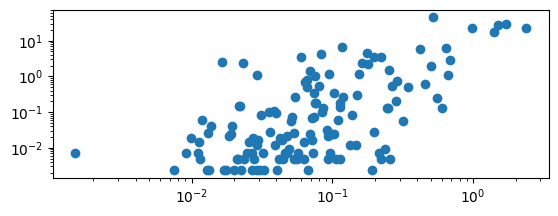

In [4]:
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax.scatter(
    x=spr.X.toarray().mean(axis=0), 
    y=scr[:, spr.var.index.to_list()].X.toarray().mean(axis=0)
)
ax.set_xscale("log")
ax.set_yscale("log")

### NMF

In [435]:
adr

AnnData object with n_obs × n_vars = 420 × 17072
    obs: 'cluster', 'leiden', 'kmeans'
    var: 'n_counts'
    uns: 'log1p', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'kmeans_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


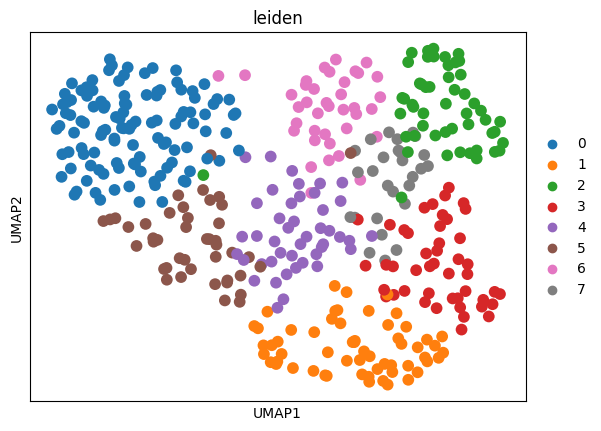

In [5]:
sc.pp.filter_genes(adr, min_counts=1)
sc.pp.normalize_total(adr)
sc.pp.log1p(adr)

sc.tl.pca(adr)
sc.pp.neighbors(adr)
sc.tl.leiden(adr)
sc.tl.umap(adr)
sc.pl.umap(adr,color='leiden')

In [6]:
df=adr.X.transpose()
nf=3

In [7]:
#f=df.sum(axis=1) > 0
#f=np.asarray(f).reshape(-1)
#df=df[f,:]

In [8]:
n_clusters_range = [x for x in range(1, 10)]
sse = [sk.cluster.KMeans(n_clusters=n_clusters).fit(adr.obsm["X_pca"]).inertia_ for n_clusters in n_clusters_range]

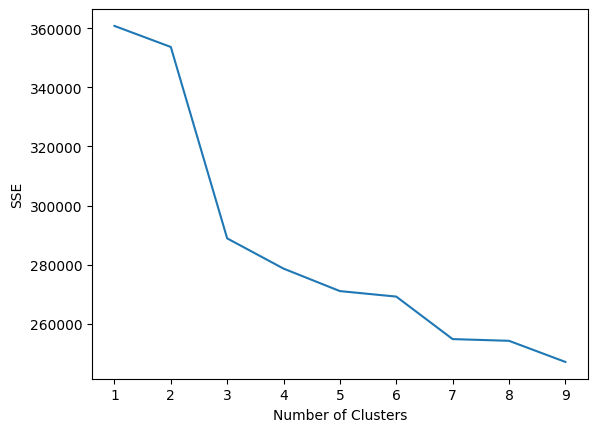

In [9]:
plt.plot(n_clusters_range, sse)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [10]:
kln = kn.KneeLocator(n_clusters_range, sse, curve="convex", direction="decreasing")
nf = max(kln.elbow,3)

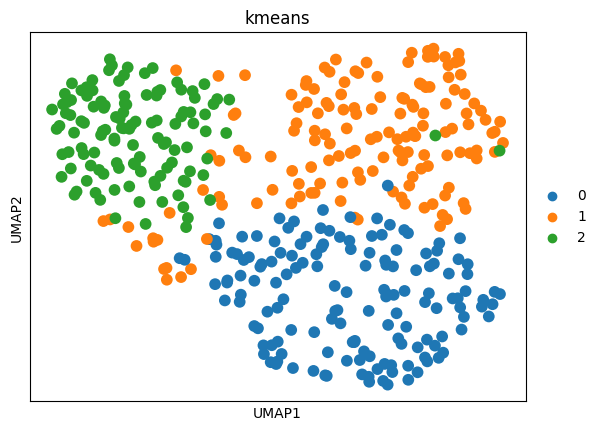

In [11]:
flag=True
minCell=10
while (flag):
    flag=False
    kmeans = sk.cluster.KMeans(n_clusters=nf).fit(adr.obsm['X_pca'])
    labels=kmeans.labels_
    for i in range(nf-1):
        if sum(labels==i) < minCell:
            nf=nf-1
            flag=True

nf=max(nf,2)

kmeans = sk.cluster.KMeans(n_clusters=nf).fit(adr.obsm['X_pca'])
labels=kmeans.labels_
adr.obs['kmeans']=labels.astype('str',copy=False)
sc.pl.umap(adr,color='kmeans')


In [12]:
sc.tl.leiden(adr)

In [13]:
adr.obs['kmeans']=adr.obs['leiden']
nf=max(adr.obs['leiden'].astype('int'))+1
adr.obs
nf


8

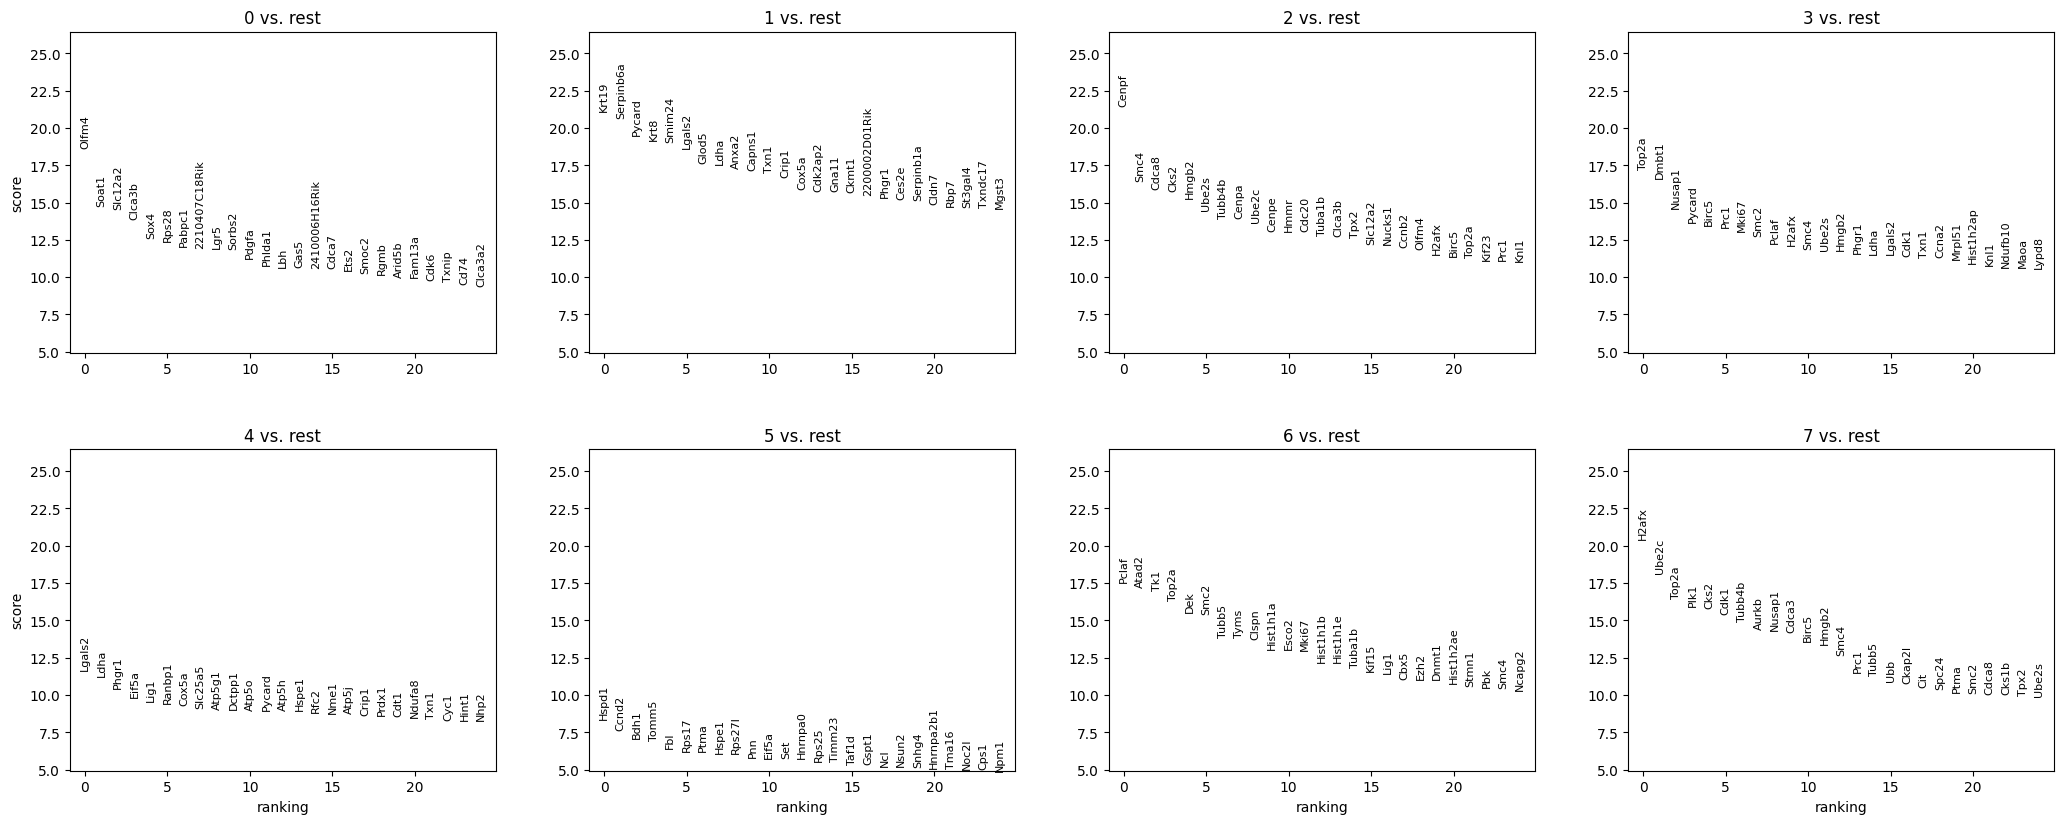

In [14]:
sc.tl.rank_genes_groups(adr, 'kmeans')
sc.pl.rank_genes_groups(adr, n_genes=25)

#### Initializing W and H Matrices 

In [215]:
# W matrix constructed from the rank_genes_groups scores for the number of clusters.
Winit = (lambda arr: np.where(arr < 0, 0.1, arr))(
    pd.concat(
        [sc.get.rank_genes_groups_df(adr, index).set_index("names")["scores"] for index in list(adr.uns["rank_genes_groups"]["names"].dtype.names)], 
        axis=1
    ).reindex(adr.var.index).values.astype(np.float64)
)
# H matrix constructed from cells belonging to a certain cluster (1 for belonging, 0.1 for not belonging)
Hinit = pd.get_dummies(adr.obs["kmeans"], dtype="float").replace(0, 0.1).values.T

In [216]:
shared_genes_mask_sp=np.isin(adr.var.index.to_list(),ad_sp.var.index.to_list()) 

shared_genes_mask=np.isin(adr.var.index.to_list(),adr.var.index.to_list())

In [217]:
W, H, _ = sk.decomposition.non_negative_factorization(
    df[shared_genes_mask],
    W=Winit[shared_genes_mask, :].astype("float32"),
    H=Hinit.astype("float32"),
    init="custom",
    alpha_W=0,
    alpha_H=0,
    l1_ratio=1.0
)
Wsp, Hsp, _ = sk.decomposition.non_negative_factorization(
    df[shared_genes_mask_sp],
    W=Winit[shared_genes_mask_sp, :].astype("float32"),
    H=Hinit.astype("float32"),
    init="custom",
    alpha_W=0,
    alpha_H=0,
    l1_ratio=1.0
)
RMSE = lambda A, B: np.sqrt(sk.metrics.mean_squared_error(A, B))
print(f"{RMSE(df[shared_genes_mask, :].toarray(), W @ H)=}")
print(f"{RMSE(df[shared_genes_mask_sp, :].toarray(), Wsp @ Hsp)=}")

RMSE(df[shared_genes_mask, :].toarray(), W @ H)=np.float64(0.34924946805617196)
RMSE(df[shared_genes_mask_sp, :].toarray(), Wsp @ Hsp)=np.float64(0.2661899281283767)


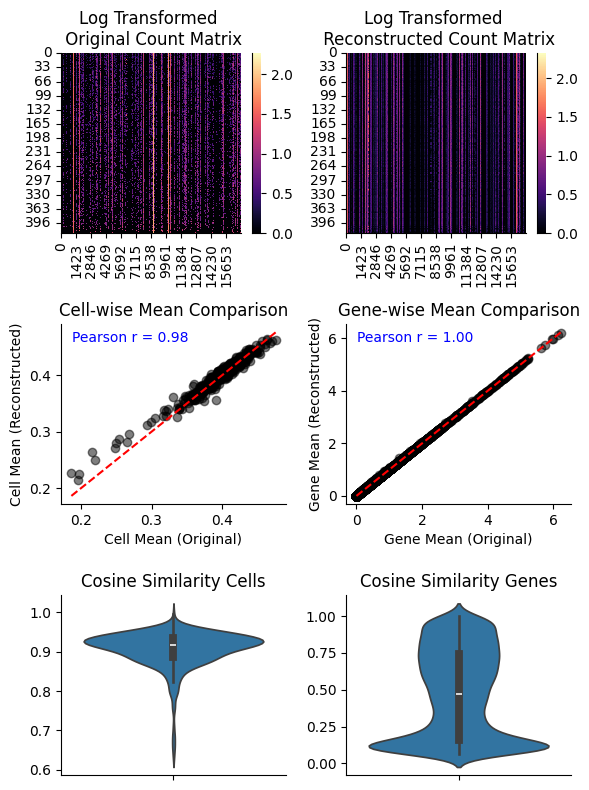

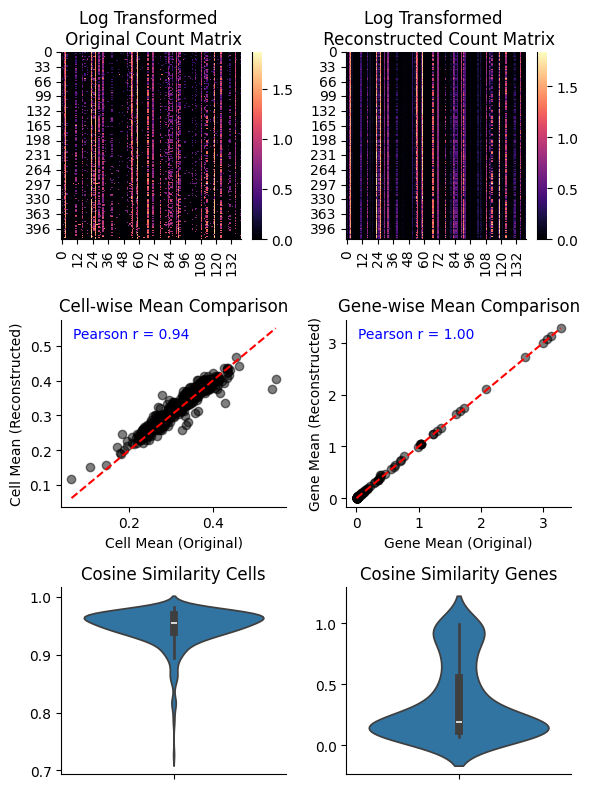

In [218]:
benchmark_reconstruction(df[shared_genes_mask].toarray().T, (W @ H).T)
benchmark_reconstruction(df[shared_genes_mask_sp].toarray().T, (Wsp @ Hsp).T)

In [219]:
w = W[shared_genes_mask_sp,:]
mask=np.isin(adr.var.index.to_list(),ad_sp.var.index.to_list())
genes=adr.var.index[mask].to_list()
spr=ad_sp[ad_sp_a.obs['nico_ct'] == 'Stem/TA',genes]
v=spr.X.transpose()

In [220]:
w = W[shared_genes_mask_sp,:]
v = ad_sp[ad_sp_a.obs["nico_ct"] == celltype, adr[:, np.isin(adr.var_names, ad_sp.var_names)].var_names].X.T

In [221]:
subidx, compidx = (lambda arr, n: (arr[:n], arr[n:]))(
    arr=np.random.permutation(np.arange(0, Wsp.shape[0])),
    n=100
)

In [290]:
vl = v[subidx,:]
w = W[shared_genes_mask_sp,:][subidx,:]
h = np.ones((W.shape[1],vl.shape[1]))
rmse = []
max_iter = 100
for i in range(max_iter):
    h = h*(w.T@vl)/(w.T@w@h)
    vt = w@h
    res = (vl - vt)**2
    rmse.append(sum(res.sum(axis=1)))

In [252]:
def non_negative_factorization_reimplementation(
        X: np.array, 
        W: Union[None, np.array]=None, 
        H: Union[None, np.array]=None, 
        n_components: Union[None, int]=None, 
        update_H: bool=True,
        max_iter: int=200
) -> tuple[np.array, np.array, int]:

    if n_components is None:
        if H is not None:
            n_components = H.shape[0]
        if W is not None:
            n_components = W.shape[1]
        else:
            n_components = min(X.shape)
    if W is None:
        W = np.ones((X.shape[0], n_components))
    if H is None:
        H = np.ones((n_components, X.shape[1]))
    
    for _ in tqdm(range(max_iter)):
        W = (W.T * (H @ X.T) / (H @ H.T @ W.T + 1e-9)).T
        if update_H:
            H = (H * (W.T @ X) / (W.T @ W @ H + 1e-9))
    return W, H, max_iter

In [292]:
w_t, h_t, _ = non_negative_factorization_reimplementation(v[subidx].T, W=np.ones((W.shape[1], vl.shape[1])).T, H=W[shared_genes_mask_sp][subidx].T, update_H=False)

100%|██████████| 200/200 [00:00<00:00, 16871.02it/s]


In [395]:
v.T.shape

(997, 140)

In [402]:
(h_t.T @ W[shared_genes_mask_sp].T).shape

(100, 140)

In [404]:
w.shape, h.shape

((100, 8), (8, 997))

In [422]:
w_t.shape

(997, 8)

In [ ]:
w

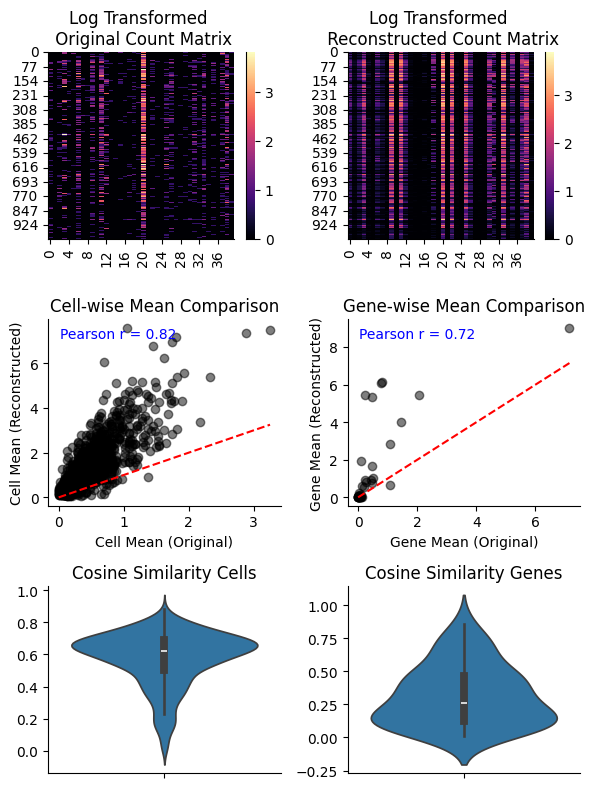

In [434]:
benchmark_reconstruction(
    v[compidx].T,
    (W[shared_genes_mask_sp][compidx] @ w_t.T).T
)

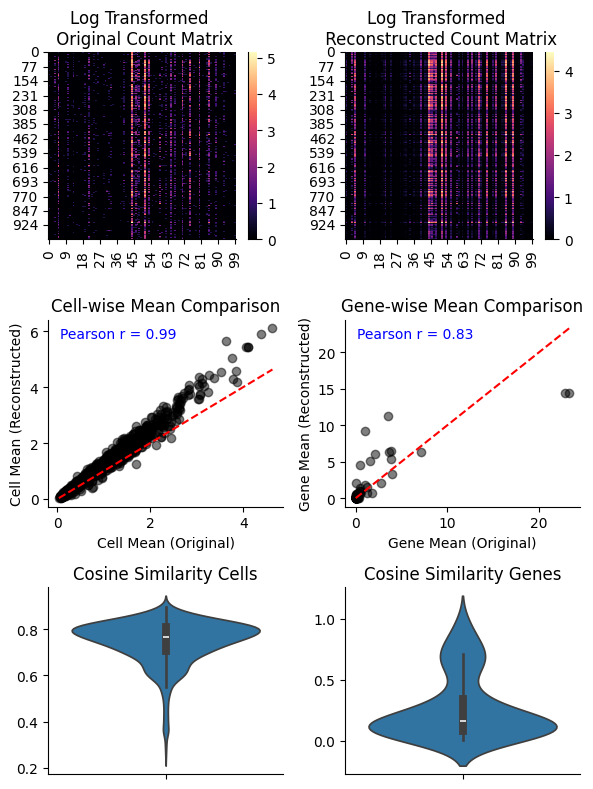

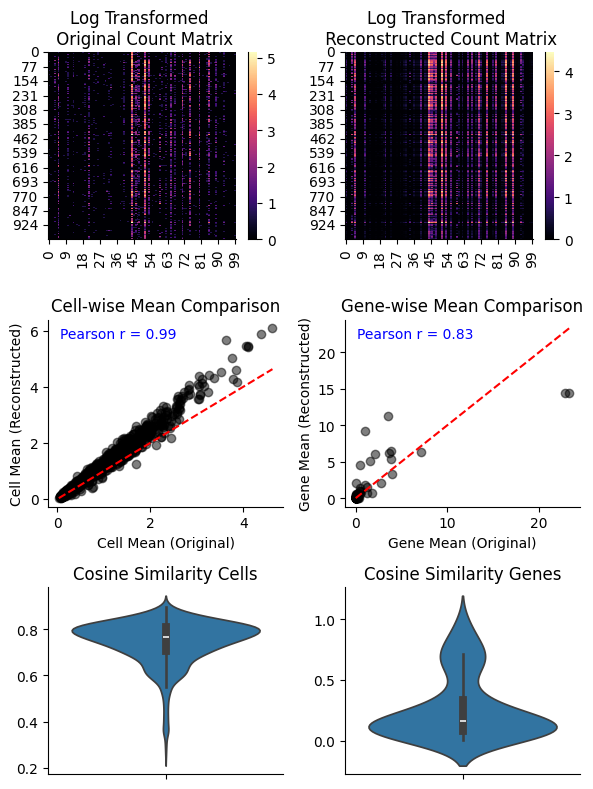

In [293]:
benchmark_reconstruction(v[subidx].T, (w_t @ h_t))
benchmark_reconstruction(v[subidx].T, (w_t @ h_t))

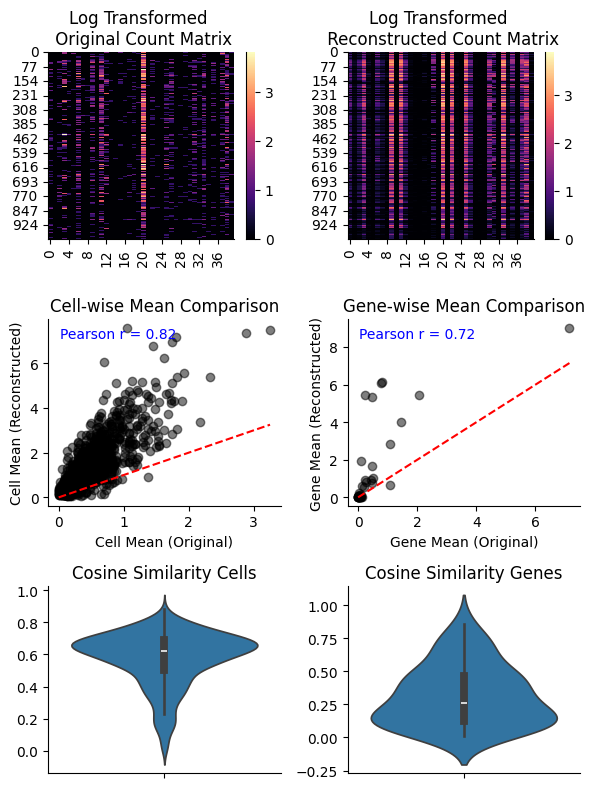

In [282]:
benchmark_reconstruction(v[compidx].T, (w_t @ W[shared_genes_mask_sp][compidx].T))

In [382]:


vl = v[subidx,:]
w = W[shared_genes_mask_sp,:][subidx,:]
h = np.ones((W.shape[1],vl.shape[1]))
rmse = []
max_iter = 100
for i in range(max_iter):
    h = h*(w.T@vl)/(w.T@w@h)
    vt = w@h
    res = (vl - vt)**2
    rmse.append(sum(res.sum(axis=1)))

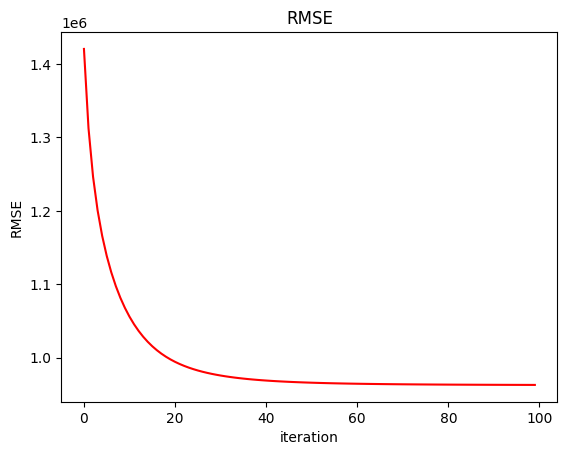

In [310]:

plt.title("RMSE") 
plt.xlabel("iteration") 
plt.ylabel("RMSE") 
plt.plot(range(max_iter), rmse, color ="red") 
plt.show()

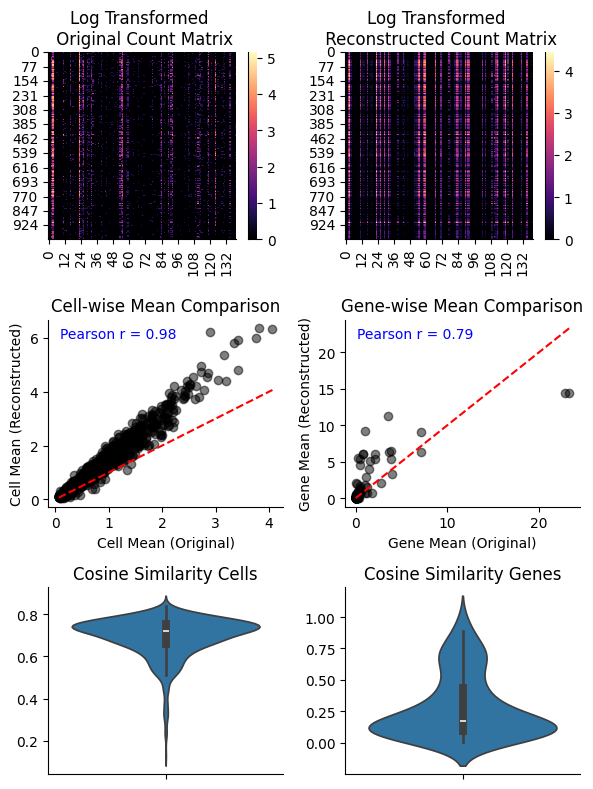

In [394]:
benchmark_reconstruction(v.T, (W[shared_genes_mask_sp] @ h).T)

PearsonRResult(statistic=np.float64(0.801014690972731), pvalue=np.float64(5.396372352597789e-10))


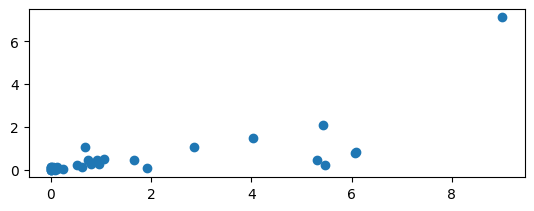

In [390]:
v1 = W[shared_genes_mask_sp,:][compidx]@h
x = v1.mean(axis=1)
y = v[compidx].mean(axis=1)
i = 44
#x = v1[compidx,i]
#y = v[compidx,i]
p = 1e-3
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

ax.scatter(sparse_to_numpy(lambda a, b: a + b)(x, p), sparse_to_numpy(lambda a, b: a + b)(y, p))
#ax.set_xscale('log')
#ax.set_yscale('log')
print(pearsonr(np.log(x+p),np.log(y+p)))

PearsonRResult(statistic=np.float64(0.9738573416620259), pvalue=np.float64(0.0))


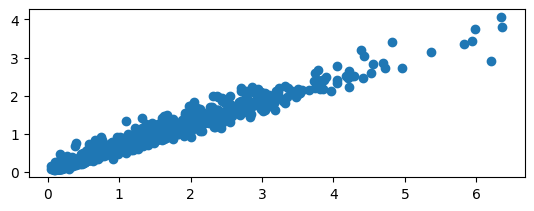

In [335]:
v1 = W[shared_genes_mask_sp,:]@h
x = v1.mean(axis=0)
y = v.mean(axis=0)
i = 44
#x = v1[compidx,i]
#y = v[compidx,i]
p = 1e-3
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

ax.scatter(sparse_to_numpy(lambda a, b: a + b)(x, p), sparse_to_numpy(lambda a, b: a + b)(y, p))
#ax.set_xscale('log')
#ax.set_yscale('log')
print(pearsonr(np.log(x+p),np.log(y+p)))

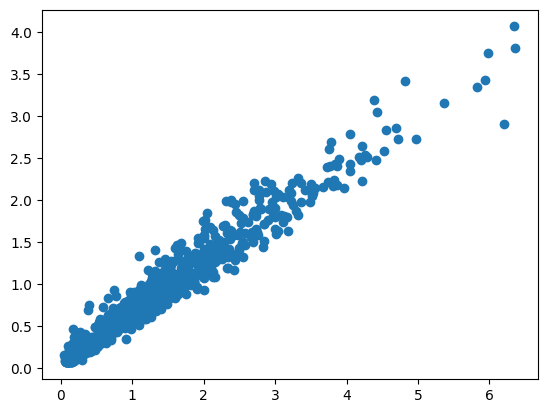

In [345]:

plt.scatter(np.array(x+p),np.array(y+p))

In [352]:
W[shared_genes_mask_sp].shape

(140, 8)

PearsonRResult(statistic=np.float64(0.1957012317252999), pvalue=np.float64(0.22619474218806174))


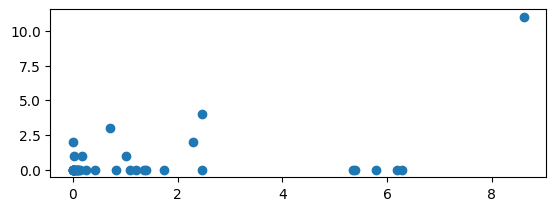

In [346]:
v1 = W[shared_genes_mask_sp,:]@h
x = v1.mean(axis=0)
y = v.mean(axis=0)
i = 1
x = v1[compidx,i]
y = v[compidx,i]
p = 1e-3
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

ax.scatter(np.array(x+p),np.array(y+p))
#ax.set_xscale('log')
#ax.set_yscale('log')
print(pearsonr(np.log(x+p),np.log(y+p)))

PearsonRResult(statistic=np.float64(0.801014690972731), pvalue=np.float64(5.396372352597789e-10))


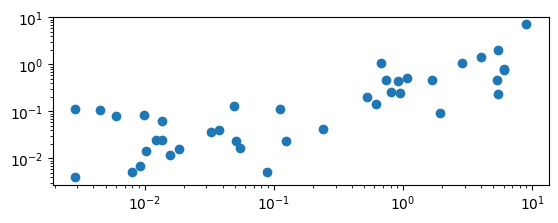

In [389]:
v1 = W[shared_genes_mask_sp,:][compidx,]@h
x = v1.mean(axis=1)
y = v[compidx,].mean(axis=1)
#i = 5
#x = v1[:,i]
#y = v[compidx,i]
p = 1e-3
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

ax.scatter(np.array(x+p),np.array(y+p))
ax.set_xscale('log')
ax.set_yscale('log')
print(pearsonr(np.log(x+p),np.log(y+p)))

PearsonRResult(statistic=np.float64(0.925024234006247), pvalue=np.float64(0.0))


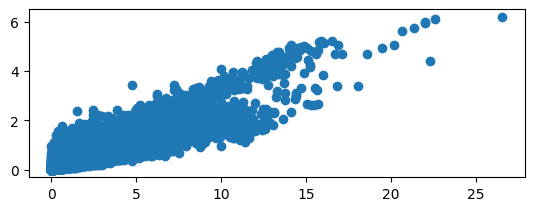

In [229]:
v1 = W@h
x = v1.mean(axis=1)
y = V.mean(axis=1)
p = 1e-3
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

ax.scatter(np.array(x+p),np.array(y+p))
#ax.set_xscale('log')
#ax.set_yscale('log')
print(pearsonr(np.log(x+p),np.log(y+p)))

In [230]:
WinitT=Winit[shared_genes_mask_sp,:].T.astype('float32').copy(order='C')
HinitT=Hinit.T.astype('float32').copy(order='C')
dfT=df[shared_genes_mask_sp,:].T
print(WinitT.shape)
print(HinitT.shape)
print(dfT.shape)

(8, 140)
(420, 8)
(420, 140)


In [231]:
modelT=sk.decomposition.NMF(n_components=nf, init='custom',alpha_W=0, alpha_H=0, l1_ratio=1.0)
WT = modelT.fit_transform(dfT,H=WinitT, W=HinitT)

In [232]:
HinitT.shape

(420, 8)

In [233]:
#W, H, _ = sk.decomposition.non_negative_factorization(
#    ad_sp[ad_sp_a.obs["nico_ct"] == celltype].X.transpose(),
#    H=WinitT,
#    W=HinitT,
#    #init="custom",
#    #alpha_W=0,
#    #alpha_H=0,
#    #l1_ratio=1.0
#
#)

In [234]:
#benchmark_reconstruction(ad_sp[ad_sp_a.obs["nico_ct"] == celltype].X.transpose(), W @ H)

In [235]:
spr=ad_sp[ad_sp_a.obs['nico_ct'] == 'Stem/TA']
dfsp=spr.X.transpose()
modelHsp.transform(dfsp)

ValueError: X has 997 features, but NMF is expecting 420 features as input.

In [ ]:
i = 0
x = Wsp[:,i]
y = W[shared_genes_mask_sp,i]
p = 1e-3
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

ax.scatter(np.array(x+p),np.array(y+p))
#ax.set_xscale('log')
#ax.set_yscale('log')
print(pearsonr(np.log(x+p),np.log(y+p)))

IndexError: boolean index did not match indexed array along axis 0; size of axis is 241 but size of corresponding boolean axis is 17072

PearsonRResult(statistic=0.6944141787966103, pvalue=1.0146132912124575e-61)


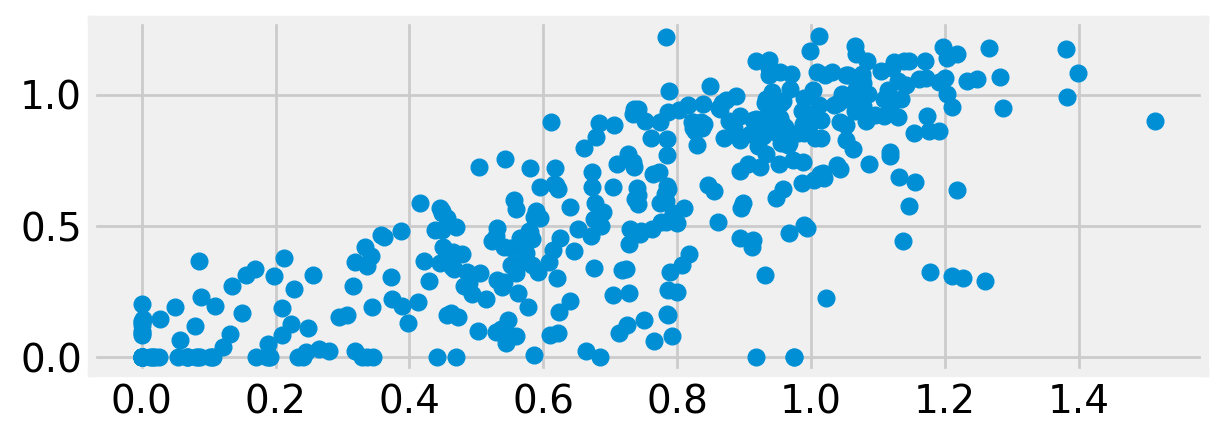

In [ ]:
i = 0
x = Hsp[i,:]
y = H[i,]
p = 1e-3
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

ax.scatter(np.array(x+p),np.array(y+p))
#ax.set_xscale('log')
#ax.set_yscale('log')
print(pearsonr(np.log(x+p),np.log(y+p)))

PearsonRResult(statistic=0.9997217468047572, pvalue=0.0)


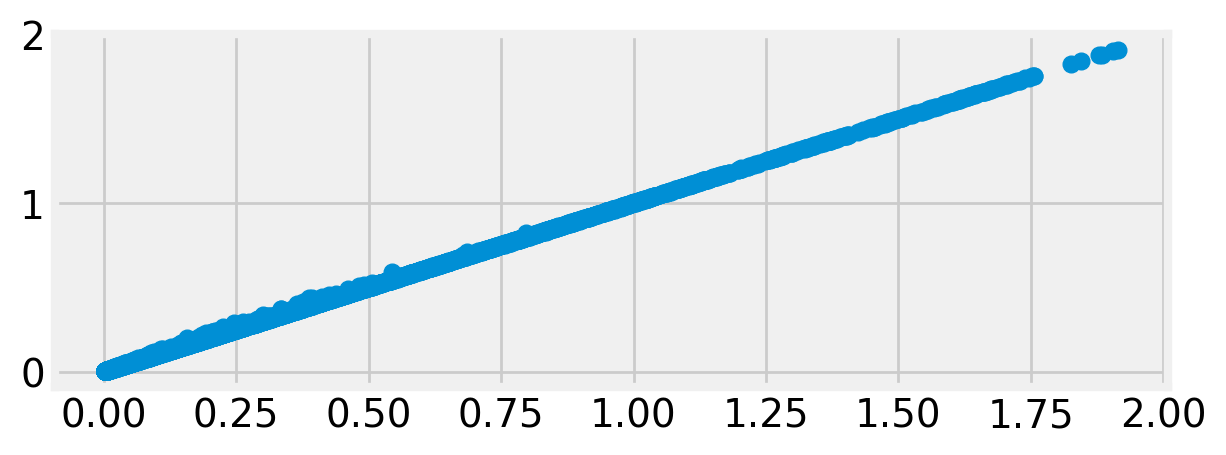

In [ ]:

x=df.toarray().mean(axis=1)
y=V.mean(axis=1)

i=5
p=0.001
#x=df.toarray()[:,i]
#y=V[:,i]
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

ax.scatter(np.array(x+p),np.array(y+p))
#ax.set_xscale('log')
#ax.set_yscale('log')
print(pearsonr(np.log(x+p),np.log(y+p)))

In [ ]:
RMSE

0.19976123

In [ ]:
dfa=df.toarray()
mat=np.zeros((dfa.shape[0],H.shape[0]),dtype=float)
for i in range(dfa.shape[0]):
    g=dfa[i,:]
    for j in range(H.shape[0]):
        fa=H[j,:]
        #corr,_ = sp.stats.pearsonr(g,fa)
        corr,_ =sp.stats.spearmanr(g,fa)
        #corr=np.corrcoef(g,fa)
        mat[i,j]=corr
mat=np.nan_to_num(mat)

In [ ]:
mat[np.argsort(mat[:,2]),:]

array([[-0.22481851,  0.89746647, -0.82588308],
       [-0.22985414,  0.90709915, -0.81140671],
       [-0.20567266,  0.80245186, -0.77552171],
       ...,
       [-0.05036811, -0.76215664,  0.82672188],
       [-0.14420713, -0.68299274,  0.83037039],
       [-0.01634866, -0.77656686,  0.84163202]])

In [ ]:
WinitR=Winit[shared_genes_mask,:]
cv=np.zeros(WinitR.shape[1],dtype=float)
for i in range(WinitR.shape[1]):
    corr,_ =sp.stats.spearmanr(W[:,i],WinitR[:,i])
    cv[i]=corr
cv


array([0.39610097, 0.13943654, 0.50771925])

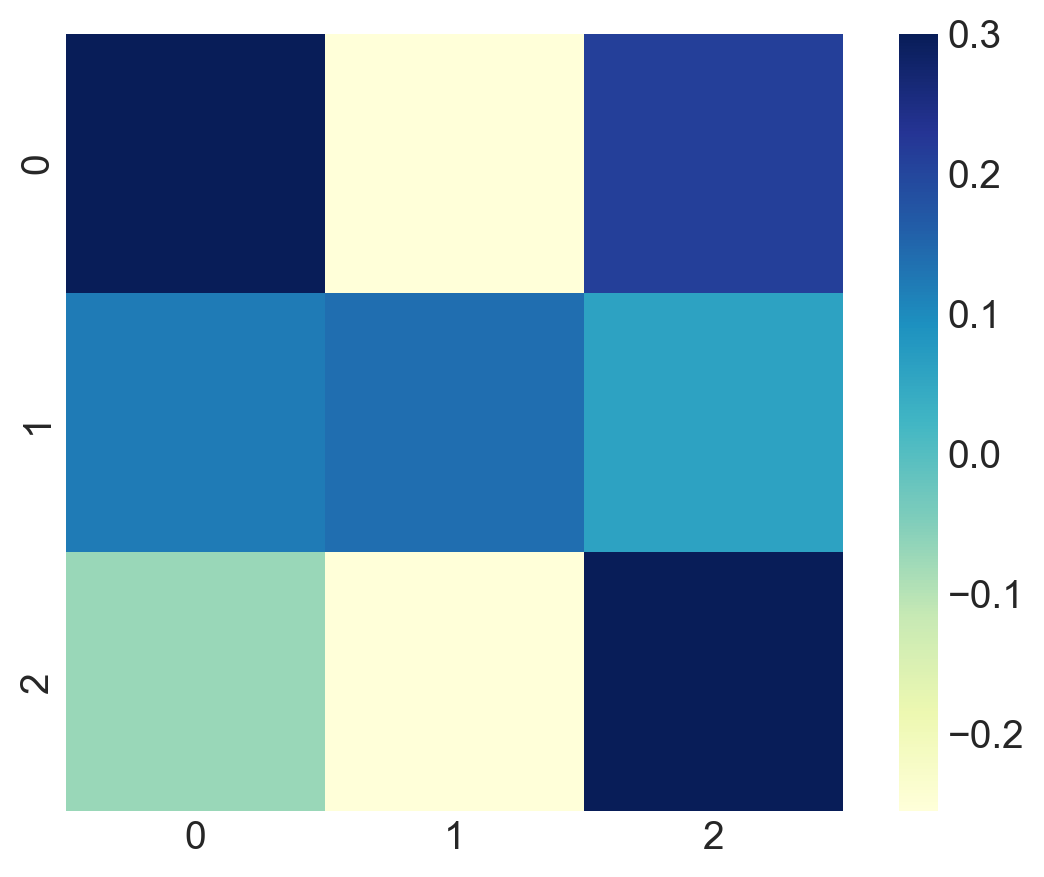

In [ ]:
WinitR=Winit[shared_genes_mask,:]

cv=np.zeros((WinitR.shape[1],WinitR.shape[1]),dtype=float)
for i in range(WinitR.shape[1]):
    for j in range(WinitR.shape[1]):
        corr,_ =sp.stats.spearmanr(W[:,i],WinitR[:,j])
        cv[i,j]=corr

mask = np.zeros_like(cv)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(cv, vmax=.3, square=True,  cmap="YlGnBu")
    plt.show()

In [ ]:
cv

array([[ 0.39610097, -0.25534521,  0.21313558],
       [ 0.12060507,  0.13943654,  0.06002158],
       [-0.0727063 , -0.25528231,  0.50771925]])

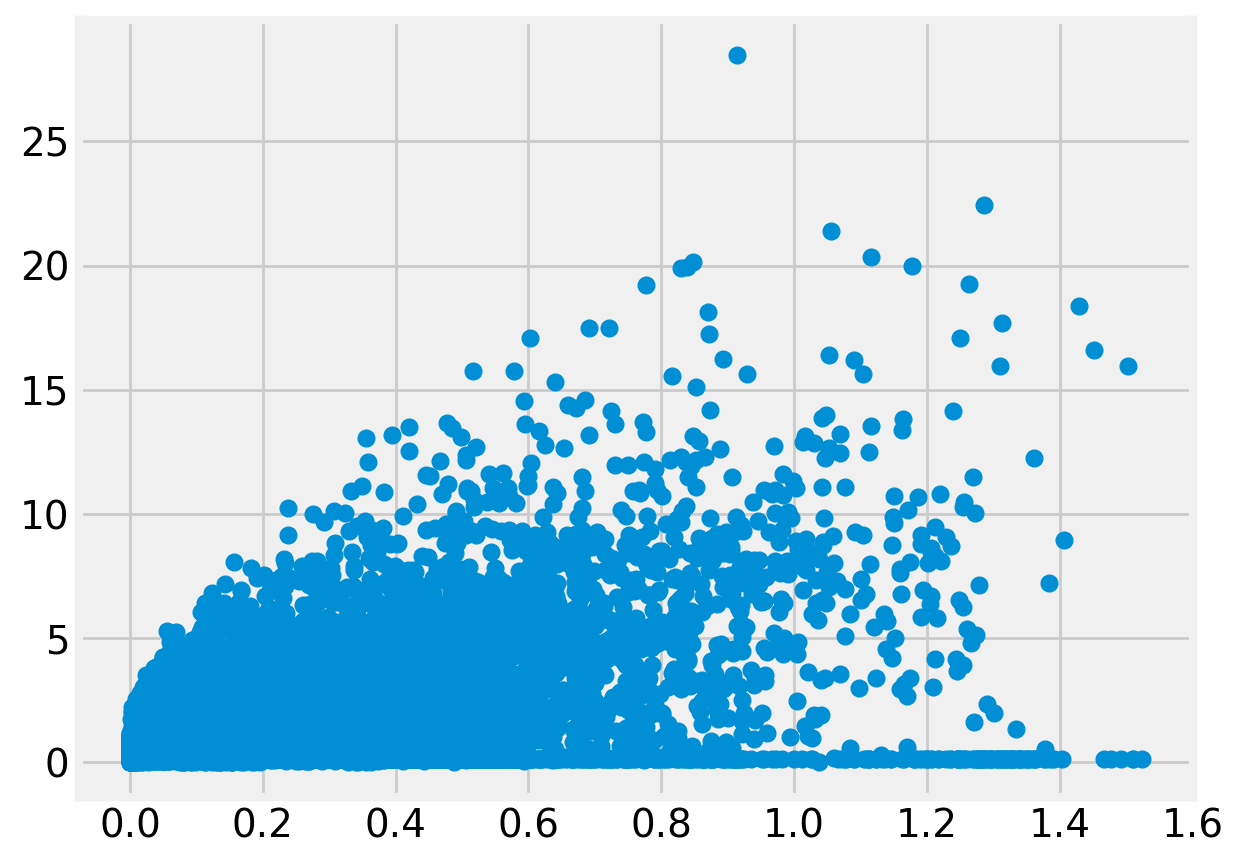

In [ ]:
WinitR=Winit[shared_genes_mask,:]
i=2
j=2
plt.scatter(W[:,i],WinitR[:,j])
plt.show()

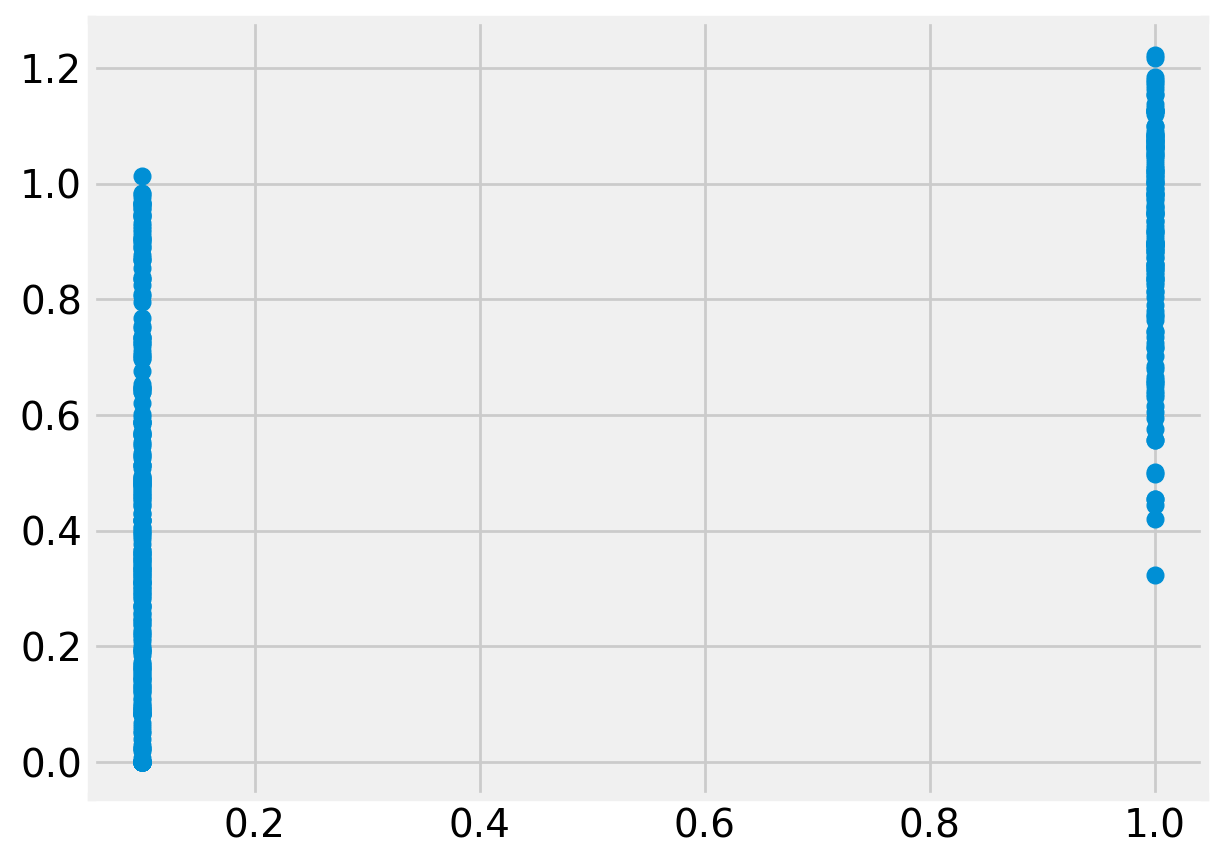

In [ ]:
plt.scatter(Hinit[0,:], H[0,:])
plt.show()

In [ ]:
adH = sc.AnnData(H.transpose())
adH.obs = adr.obs
adH.obsm = adr.obsm


In [ ]:
Z = get_latent_representation(model,ad[ad.obs['cluster'] == 'Stem/TA'].copy())
adZ = sc.AnnData(Z)
adZ.obs = adr.obs
adZ.obsm = adr.obsm


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


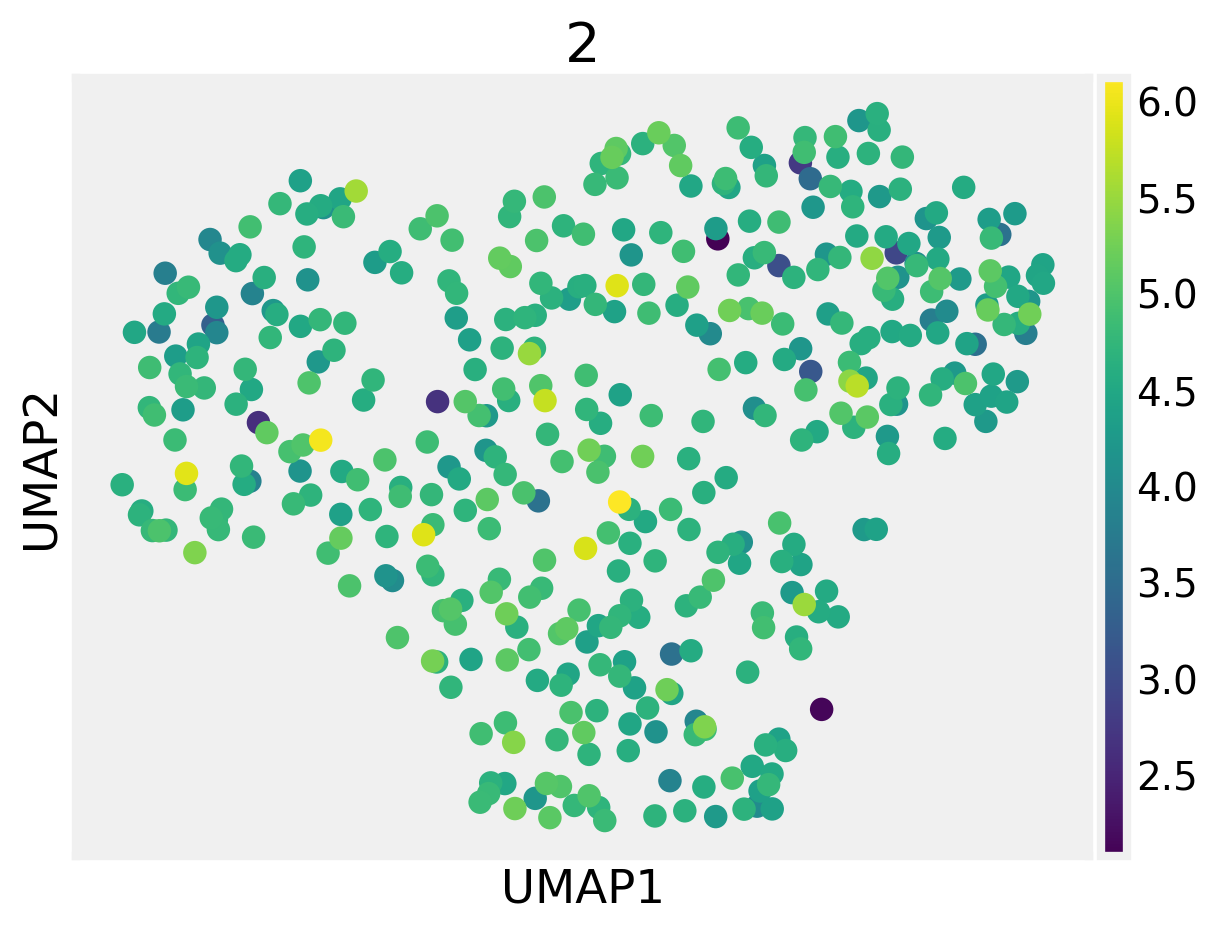

In [ ]:
sc.pl.umap(adZ,color='2')

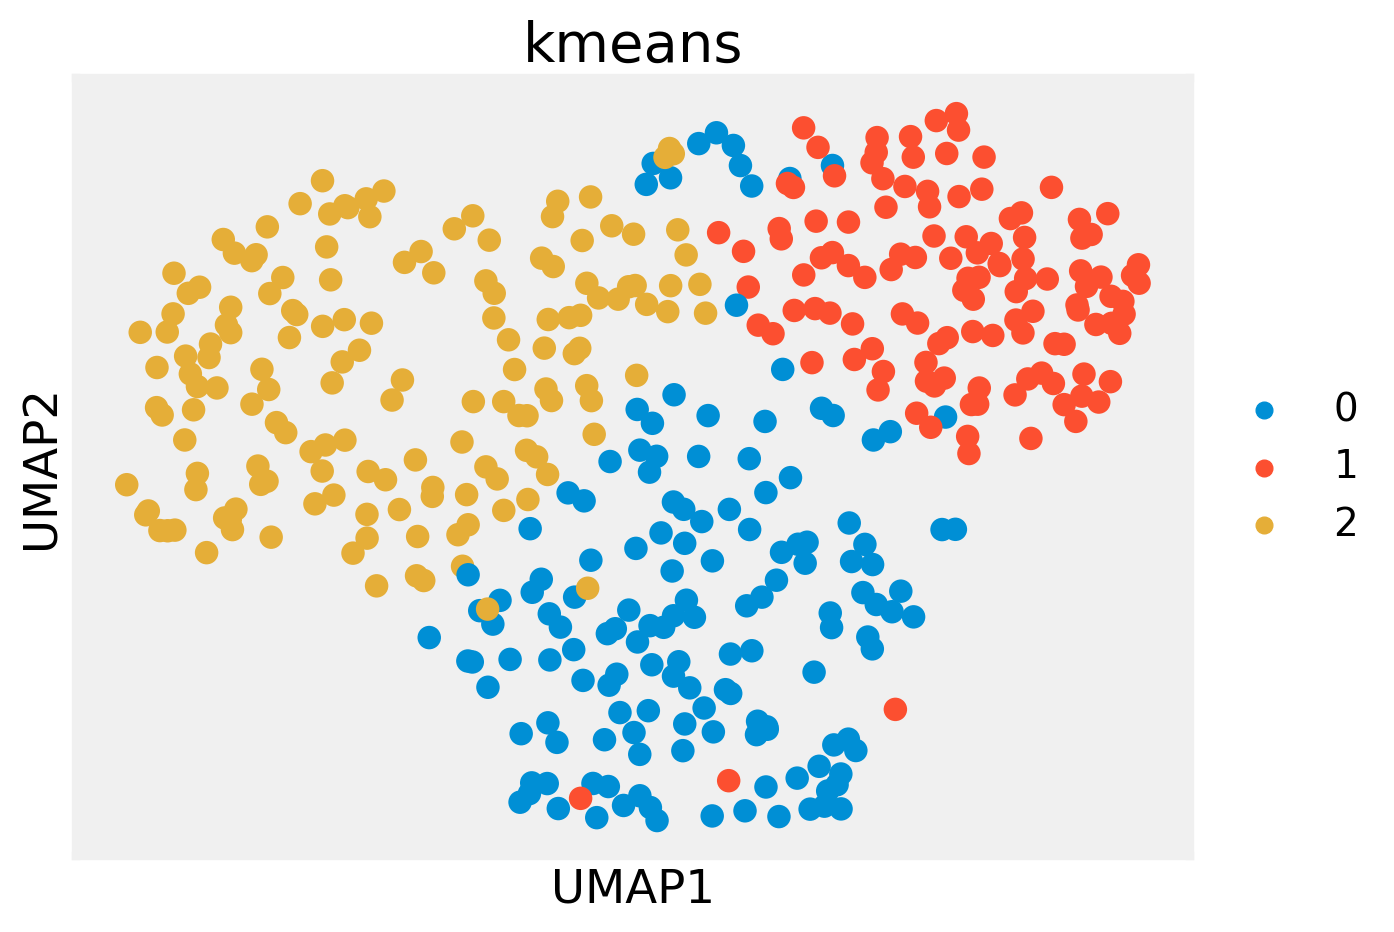

In [ ]:
sc.pl.umap(adH,color='kmeans')

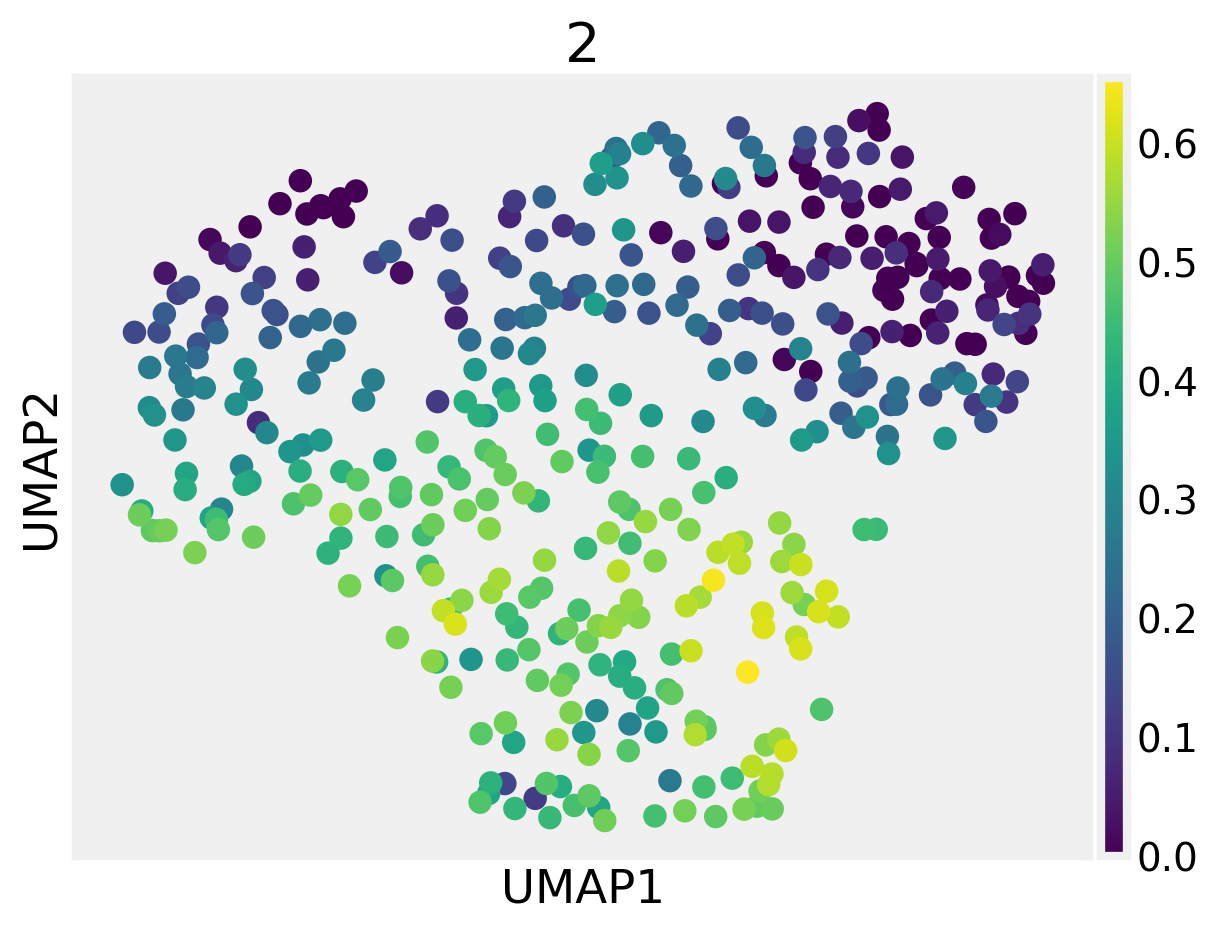

In [ ]:
sc.pl.umap(adH,color='2')

In [ ]:
i=1
j=1
Z.shape

(420, 5)

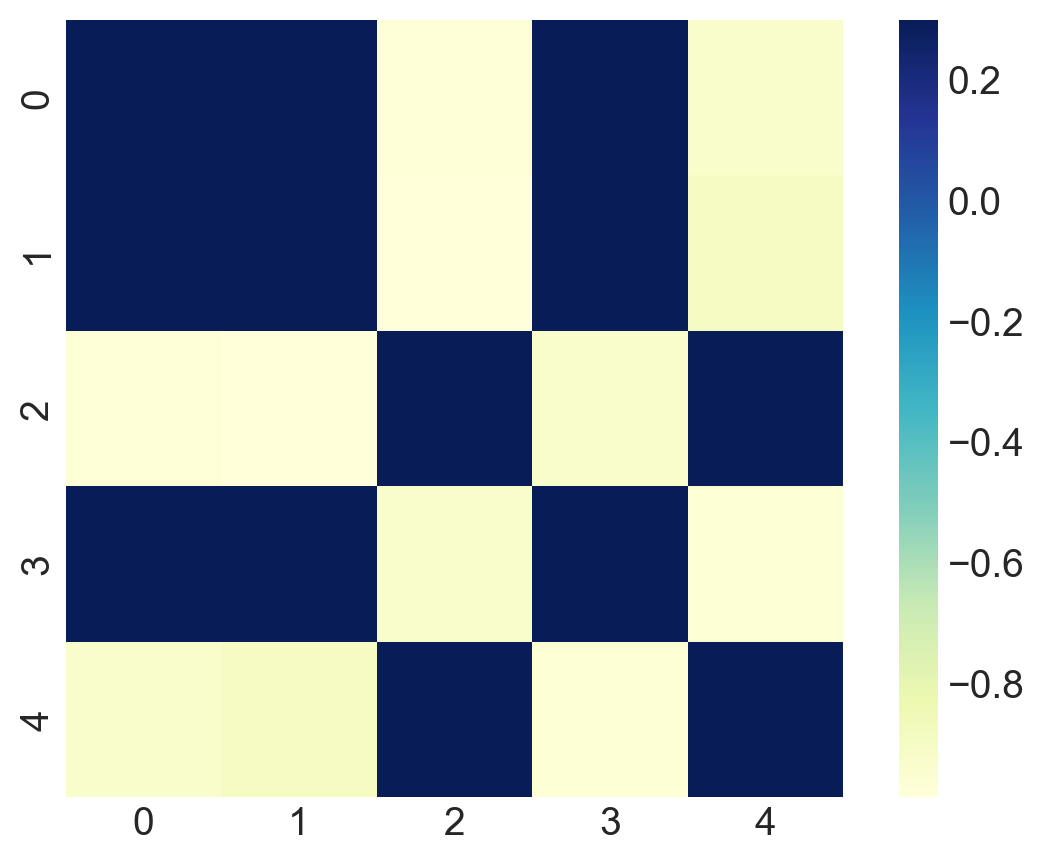

In [ ]:
cv=np.zeros((Z.shape[1],Z.shape[1]),dtype=float)
for i in range(Z.shape[1]):
    for j in range(Z.shape[1]):
        corr,_ =sp.stats.spearmanr(Z[:,i],Z[:,j])
        cv[i,j]=corr

mask = np.zeros_like(cv)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(cv, vmax=.3, square=True,  cmap="YlGnBu")
    plt.show()

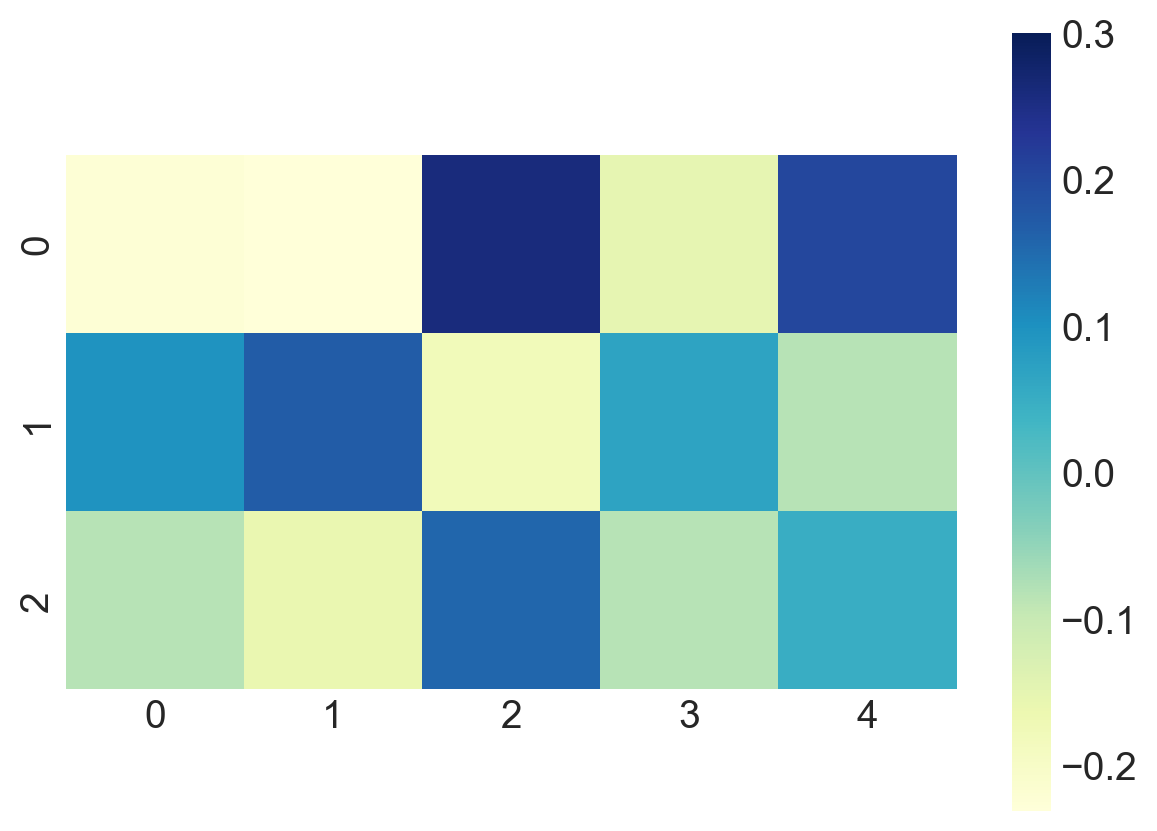

In [ ]:


cv=np.zeros((H.shape[0],Z.shape[1]),dtype=float)
for i in range(H.shape[0]):
    for j in range(Z.shape[1]):
        corr,_ =sp.stats.spearmanr(H[i,:],Z[:,j])
        cv[i,j]=corr

mask = np.zeros_like(cv)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(cv, vmax=.3, square=True,  cmap="YlGnBu")
    plt.show()

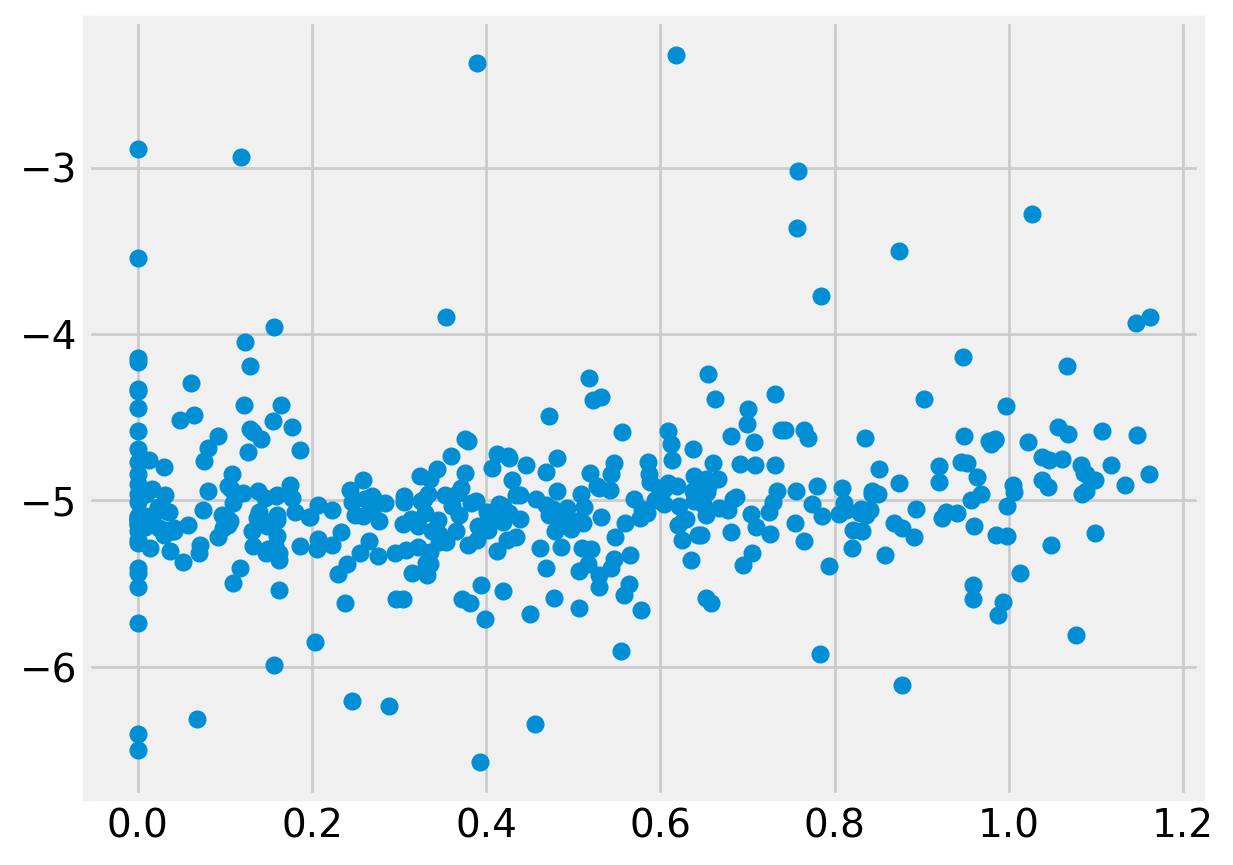

SignificanceResult(statistic=0.1711617645182433, pvalue=0.00042612375122592054)


In [ ]:
i=1
j=1
plt.scatter(H[i,:], Z[:,j])
plt.show()
print(sp.stats.spearmanr(H[i,:],Z[:,j]))

In [ ]:
# explained_variance_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html#sklearn.metrics.explained_variance_score

# https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.predict
